<a href="https://colab.research.google.com/github/jaredwool/causal_modeling/blob/main/WFH_Causal_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How does Working from Home (WFH) affect productivity?
## A Synthetic Example to illustrate different Causal approaches that are facilitated through the use of DAGs
This example is based loosely on an example found on the datacamp.com website but I have expanded upon it and added context for clarity

https://www.datacamp.com/tutorial/intro-to-causal-ai-using-the-dowhy-library-in-python

*   List item
*   List item



In [3]:
# install packages
!pip install seaborn statsmodels dowhy lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 11.4 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
import statsmodels.api as sm

import dowhy
from dowhy import CausalModel


In [10]:
# Create a dataset
noise_level = 0.2
n_samples = 10000
random.seed(1)
np.random.seed(1)

# Confounder variables (these have no parents and are random noise)
introversion = np.random.normal(loc=5, scale = 1.5, size = n_samples)
numkids = np.random.choice(np.arange(7), size = n_samples, p = [0.3, 0.2, 0.15, 0.15, 0.1, 0.05, 0.05])

# Instrumental variable (has no parents and is an indicator variable affecting a random subset of the population)
subway = np.random.choice([0,1], size = n_samples, p = [0.80, 0.20])

# Treatment variable (Variable of interest) affected by confounders as well as instrumental variable
wfh = 0.4*introversion + 0.6*numkids + noise_level*np.random.randn(n_samples)
wfh = np.where(wfh > np.median(wfh), 1, 0)
wfh = np.where(subway == 1, 1, wfh) # ensure everyone impacted by the subway is also working from home

# Mediator variable, impacted by wfh alone and affects the outcome of interest
min_saved = wfh * np.random.normal(loc = 60, scale = 15, size = n_samples) # Extra minutes are normally distributed with mean 60 and std 15

# outcome is affected by the mediator as well as the confounders
productivity = 0.05*min_saved + 0.4*introversion - 0.6*numkids + noise_level*(np.random.randn(n_samples))

# Spurious collider impacted by treatment and outcome
pm = np.round((3*wfh + 8*productivity + 5*(np.random.randn(n_samples)))/10, 0) + 2

fulldf = pd.DataFrame({'introversion':introversion, 'numkids':numkids, 'subway_closure':subway, 'wfh':wfh, 'min_saved':min_saved, 'productivity':productivity, 'pm_rating':pm})
# Add an ID identifier
fulldf['emp_id']=10000 + fulldf.index

df = fulldf[['emp_id', 'numkids', 'wfh', 'productivity','introversion']]
df.head(10)

,emp_id,numkids,wfh,productivity,introversion
0,10000,4,1,3.216243,7.436518
1,10001,0,0,1.842094,4.082365
2,10002,5,1,1.487691,4.207742
3,10003,0,0,1.560975,3.390547
4,10004,0,0,2.412597,6.298111
5,10005,1,0,0.018966,1.547692
6,10006,3,1,3.623897,7.617218
7,10007,0,1,4.151433,3.858190
8,10008,1,0,1.452014,5.478559
9,10009,4,1,4.007714,4.625944


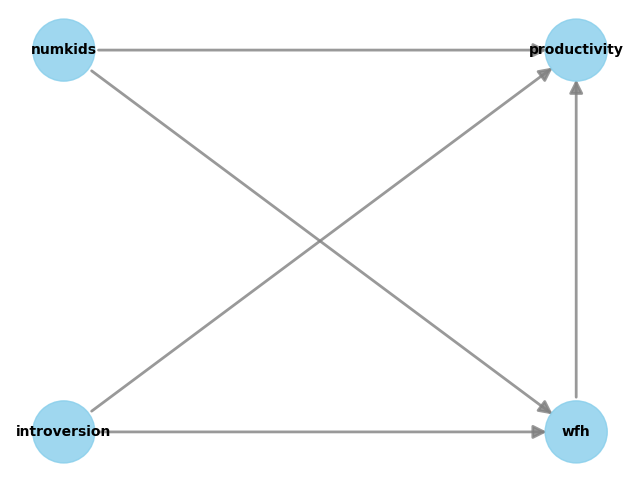

In [14]:
# create the DAG
nodes = ['introversion','wfh','numkids','productivity']
edges = [['introversion','wfh'],
         ['introversion','productivity'],
         ['wfh','productivity'],
         ['numkids','productivity'],
         ['numkids','wfh']
        ]
gml_graph = 'graph [directed 1\n'

for node in nodes:
  gml_graph += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
  gml_graph += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_graph += ']'

model = CausalModel(
    data = df,
    treatment = 'wfh',
    outcome = 'productivity',
    graph = gml_graph
)
model.view_model()

In [15]:
df.describe()

,emp_id,numkids,wfh,productivity,introversion
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,14999.50000,1.924700,0.598500,2.643524,5.014659
std,2886.89568,1.783577,0.490226,1.640374,1.498254
min,10000.00000,0.000000,0.000000,-2.623134,-0.484660
25%,12499.75000,0.000000,0.000000,1.475912,4.005613
50%,14999.50000,2.000000,1.000000,2.412462,5.012681
75%,17499.25000,3.000000,1.000000,3.795038,6.007713
max,19999.00000,6.000000,1.000000,9.022900,11.040274


Before we run a causal model let's look at a naive linear regression of productivity as a function of working from home.

In [18]:
X = df[['wfh']].astype(float)
y = df[['productivity']].astype(float)

X = sm.add_constant(X)

ols = sm.OLS(y, X).fit()

print(ols.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4140      0.020     69.192      0.000       1.374       1.454
wfh            2.0543      0.026     77.770      0.000       2.003       2.106


The naive regression approach incorrectly estiamtes the effect of working from home on productivity as 2 when the true effect is 3 as specified in our data creation (60*0.05 = 3)

## The Backdoor approach
If we are able to control for the confounders (introversion and number of kids) we can block the backdoor pathways of spurious correlation. Sometimes backdoor pathways flow through multiple parent and cousin nodes. It is sufficient to control for just one variable along each path to effectively block those backdoor pathways. This will allow us to identify the true causal relationship of X on Y

In [19]:
X = df[['wfh','numkids','introversion']].astype(float)
y = df['productivity'].astype(float)

X = sm.add_constant(X)

ols = sm.OLS(y, X).fit()

print(ols.summary().tables[1])

                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0083      0.023      0.365      0.715      -0.036       0.053
wfh              3.0022      0.017    179.170      0.000       2.969       3.035
numkids         -0.6036      0.004   -136.993      0.000      -0.612      -0.595
introversion     0.3989      0.004     90.364      0.000       0.390       0.408


Controlling for the appropriate confounders enables identification of the true causal effect of wfh on productivity.

## Colliders (children or their descendents that are affected by the variable of interest and the outcome)
But what if we control for a collider? Let's add PM rating to the data and the graph and see what happens when we control for it. We assume working from home will affect PM rating, we also assume productivity affects PM rating, thus it is a collider.

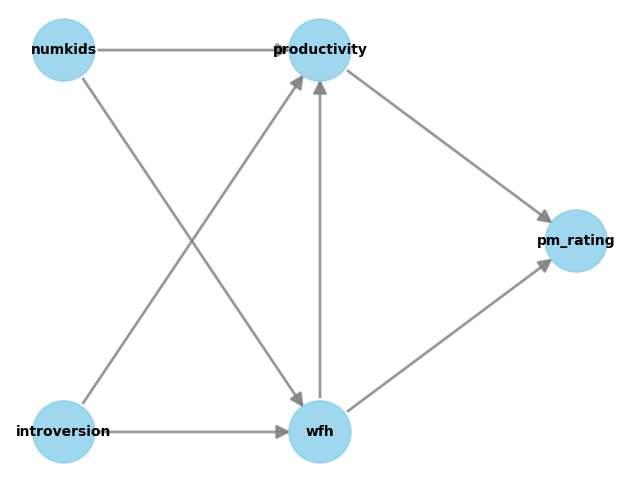

In [21]:
# add PM rating to the dataframe
df = fulldf[['emp_id', 'numkids', 'wfh', 'productivity','introversion','pm_rating']]

# create the DAG
nodes = ['introversion','wfh','numkids','productivity','pm_rating']
edges = [['introversion','wfh'],
         ['introversion','productivity'],
         ['wfh','productivity'],
         ['numkids','productivity'],
         ['numkids','wfh'],
         ['wfh','pm_rating'],
         ['productivity','pm_rating']
        ]
gml_graph = 'graph [directed 1\n'

for node in nodes:
  gml_graph += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
  gml_graph += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_graph += ']'

model = CausalModel(
    data = df,
    treatment = 'wfh',
    outcome = 'productivity',
    graph = gml_graph
)
model.view_model()

In [22]:
# Estimate the model including PM rating as a control in addition to the confounders:
X = df[['wfh','numkids','introversion','pm_rating']].astype(float)
y = df['productivity'].astype(float)

X = sm.add_constant(X)

ols = sm.OLS(y, X).fit()

print(ols.summary().tables[1])

                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.0492      0.021    -49.269      0.000      -1.091      -1.007
wfh              1.5786      0.021     75.192      0.000       1.537       1.620
numkids         -0.3493      0.004    -77.889      0.000      -0.358      -0.341
introversion     0.2317      0.004     59.606      0.000       0.224       0.239
pm_rating        0.5261      0.006     85.338      0.000       0.514       0.538


Controlling for colliders has the opposite effect compared to controlling for confounders. When we control for a confounder we block the influence of parent nodes that create spurious correlation. When we control for a child node that is a collider, we are opening up a path of spurious correlation that was previously closed when not controlling for it. Selection bias is a common form of collider bias.

## The Frontdoor Approach
Often we don't have good data on the confounders. It is still possible to identify the underlying causal effect of one variable on another with a little creativity. The frontdoor approach takes advantage of a mediator variable between the variable of interest and the outcome to estimate the true causal effect.

Let's get data on a mediator between wfh and productivity. The primary mechanism through which working from home will affect productivity is minutes saved by not commuting or getting distracted by office antics. Suppose we use location data to estimate commute time for all of our associates and call that minutes saved. We assume that Number of Kids and introversion are not correlated with commute time.

We take a two stage approach.
1.   First, we estimate the causal impact of working from home on minutes saved directly as there are no confounders in this relationship.
2.   Second we estiamte the effect of minutes saved on productivity **controlling for work from home status**.

By controlling for WFH status in the second stage, we are able to block all backdoor pathways of spurious correlation that could otherwise influence the estimate of minutes saved on productivity.

Finally we just multiply the two effects together. The effect of working from home on minutes saved which is effectively an estimate of how many minutes are saved by working from home is multiplied by our estimate of the effect of an additional minute on productivity.

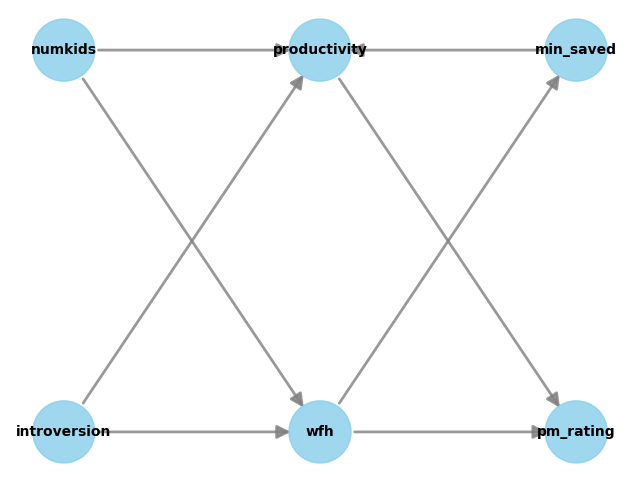

In [24]:
# Add minutes saved to the data and to the graph so we can see where it fits in
df = fulldf[['emp_id', 'numkids', 'wfh', 'productivity','introversion','pm_rating','min_saved']]

# create the DAG
nodes = ['introversion','wfh','numkids','productivity','pm_rating','min_saved']
edges = [['introversion','wfh'],
         ['introversion','productivity'],
         ['wfh','min_saved'],
         ['min_saved','productivity'],
         ['numkids','productivity'],
         ['numkids','wfh'],
         ['wfh','pm_rating'],
         ['productivity','pm_rating']
        ]
gml_graph = 'graph [directed 1\n'

for node in nodes:
  gml_graph += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
  gml_graph += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_graph += ']'

model = CausalModel(
    data = df,
    treatment = 'wfh',
    outcome = 'productivity',
    graph = gml_graph
)
model.view_model()

In [29]:
# Stage 1
X = df[['wfh']].astype(float)
y = df['min_saved'].astype(float)

X = sm.add_constant(X)
ols = sm.OLS(y, X).fit()
print(ols.summary().tables[1])
coeff1 = ols.params['wfh']

# Stage 2
X = df[['min_saved','wfh']].astype(float)
y = df['productivity'].astype(float)

X = sm.add_constant(X)
ols = sm.OLS(y, X).fit()
print(ols.summary().tables[1])
coeff2 = ols.params['min_saved']

causal_effect = coeff1*coeff2
print(f'the estimated causal effect of WFH on Productivity is  {round(causal_effect,2)}')

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.373e-15      0.184  -4.56e-14      1.000      -0.360       0.360
wfh           59.9170      0.237    252.578      0.000      59.452      60.382
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4140      0.018     77.593      0.000       1.378       1.450
min_saved      0.0504      0.001     50.757      0.000       0.048       0.052
wfh           -0.9658      0.064    -15.092      0.000      -1.091      -0.840
the estimated causal effect of WFH on Productivity is  3.02


## Instrumental Variables Approach
IV estimation relies on having an exogenous variable that is only correlated with the variable of interest and that correlation needs to be strong. It has to be uncorrelated with the outcome in all respects except through it's influence on the variable of interest. It must also be uncorrelated with anything that confounds the relationship between the variable of interest and the outcome.

### Close the Silver line metro
Suppose we lewarn that there was as subway closure that affected the ability of a portion of our workforce to come into the office and forced people along that subway line to work from home full time. This sets up what can be though of a s a natural experiment. It can be strongly argued that the subway closure has nothing to do with the confounders of number of kids or a level of introversion and therefore not affected by the unobserved confounders. It can also be argued that the closure of the subway is highly correlated with the decision to work from home for the time period in which the subway was closed. Also closing down a subway should not affect the productivity of workers in general except through it's impact on whether or not they work from home.

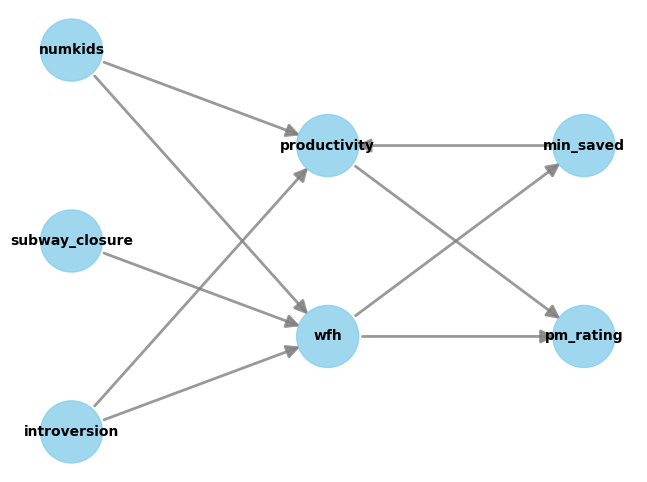

In [30]:
# Add subway closure to the data and to the graph so we can see where it fits in
df = fulldf[['emp_id', 'numkids', 'wfh', 'productivity','introversion','pm_rating','min_saved', 'subway_closure']]

# create the DAG
nodes = ['introversion','wfh','numkids','productivity','pm_rating','min_saved','subway_closure']
edges = [['introversion','wfh'],
         ['introversion','productivity'],
         ['wfh','min_saved'],
         ['min_saved','productivity'],
         ['numkids','productivity'],
         ['numkids','wfh'],
         ['wfh','pm_rating'],
         ['productivity','pm_rating'],
         ['subway_closure','wfh']
        ]
gml_graph = 'graph [directed 1\n'

for node in nodes:
  gml_graph += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
  gml_graph += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_graph += ']'

model = CausalModel(
    data = df,
    treatment = 'wfh',
    outcome = 'productivity',
    graph = gml_graph
)
model.view_model()

In [34]:
# Check the correlation between Subway Closure and WFH (should be strong)
print(round(df['wfh'].corr(df['subway_closure']),2))

0.41


### Two stage estimation process
## First stage
In the first stage we fit a predictive model of the instrumental variable on the variable of interest (the treatment variable). In this case we fit a model of subway closure on wfh status.
We then generate predicted values for wfh status based on that model. This is why it's really important to have strong correlation between the instrument and the treatment variable. The instrument has to be able to predict the treatment variable.

## Second stage
We use the predicted values from the first stage to estimate the effect of wfh on productivity. By using the predicted values we ensure that the impact of the unobserved factors is completely removed from the estimate.

In [35]:
# Stage 1
X = df[['subway_closure']].astype(float)
y = df['wfh'].astype(float)

X = sm.add_constant(X)
ols = sm.OLS(y, X).fit()
print(ols.summary().tables[1])
# generate predicted values and save as a column in the dataframe
df['wfh_pred']=ols.predict(X)


# Stage 2
X = df[['wfh_pred']].astype(float)
y = df['productivity'].astype(float)

X = sm.add_constant(X)
ols = sm.OLS(y, X).fit()
print(ols.summary().tables[1])

                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.4997      0.005     99.928      0.000       0.490       0.509
subway_closure     0.5003      0.011     44.464      0.000       0.478       0.522
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8689      0.048     17.928      0.000       0.774       0.964
wfh_pred       2.9651      0.077     38.590      0.000       2.814       3.116


<ipython-input-35-d5133a0a71cc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wfh_pred']=ols.predict(X)


And we have an estimate of the effect of wfh on productivity that is pretty close to the true effect of 3

### Question for further research.
What if the instrument has a backdoor pathway to the outcome? Would it work to block it using the back door approach? I believe it would, in the first stage one would estiamte a model of the treatment as a function of the instument and another control variable that blocks the backdoor pathway. Then when generating the predicted values for the treatment one would set all the values of the control variable to zero before generating the predicted values. This ensures that the predicted values are based only on the instrument, not on the control